#Setup
Download repos and install packages

Change working directory to TensorFlowTTS

In [1]:
!git clone https://github.com/TensorSpeech/TensorflowTTS

Cloning into 'TensorflowTTS'...
remote: Enumerating objects: 123, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 2474 (delta 64), reused 84 (delta 42), pack-reused 2351
Receiving objects: 100% (2474/2474), 35.42 MiB | 29.95 MiB/s, done.
Resolving deltas: 100% (1516/1516), done.


In [2]:
%cd TensorflowTTS
!ls -lh

/content/TensorflowTTS
total 64K
-rw-r--r--  1 root root  192 Jul  9 07:57 docker-compose.yml
-rw-r--r--  1 root root  248 Jul  9 07:57 dockerfile
drwxr-xr-x  8 root root 4.0K Jul  9 07:57 examples
-rw-r--r--  1 root root  12K Jul  9 07:57 LICENSE
drwxr-xr-x  2 root root 4.0K Jul  9 07:57 notebooks
drwxr-xr-x  2 root root 4.0K Jul  9 07:57 preprocess
-rw-r--r--  1 root root  16K Jul  9 07:57 README.md
-rw-r--r--  1 root root  198 Jul  9 07:57 setup.cfg
-rw-r--r--  1 root root 3.1K Jul  9 07:57 setup.py
drwxr-xr-x 11 root root 4.0K Jul  9 07:57 tensorflow_tts
drwxr-xr-x  2 root root 4.0K Jul  9 07:57 test


In [3]:
# Download tf-nightly only for Tensorflow Lite experiments
!pip install tf-nightly
!pip install soundfile
!pip install unidecode
!pip install PyDrive

     |████████████████████████████████| 322.8MB 48kB/s 
     |████████████████████████████████| 6.5MB 44.3MB/s 
     |████████████████████████████████| 460kB 42.2MB/s 
     |████████████████████████████████| 245kB 3.4MB/s 


#For Google Drive access to download pretrained models

Follow command line link & instructions to authorize google drive access to download pretrained models. One time authorization only.

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
mbmelgan_pretrained = drive.CreateFile({'id': '1kChFaLI7slrTtuk3pvcOiJwJDCygsw9C'})
print(mbmelgan_pretrained['title'])
mbmelgan_pretrained.GetContentFile(mbmelgan_pretrained['title'])

fastspeech3_pretrained = drive.CreateFile({'id': '1T5GOE_M27zJlCAjnanpOS9HBPUcdE9sB'})
print(fastspeech3_pretrained['title'])
fastspeech3_pretrained.GetContentFile(fastspeech3_pretrained['title'])

generator-940000.h5
model-150000.h5


#TFLite Experiments
NOTE: Requires tf-nightly 2.4dev version

In [6]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from tensorflow_tts.processor.ljspeech import LJSpeechProcessor
from tensorflow_tts.processor.ljspeech import symbols, _symbol_to_id

from tensorflow_tts.configs import FastSpeechConfig
from tensorflow_tts.configs import MultiBandMelGANGeneratorConfig

from tensorflow_tts.models import TFMelGANGenerator
from tensorflow_tts.models import TFPQMF
from tensorflow_tts.models import TFFastSpeech

from IPython.display import Audio
import soundfile as sf
import time

processor = LJSpeechProcessor(None, "english_cleaners")
sentences = ["Recent research at Harvard has shown meditating for as little as 8 weeks, can actually increase the grey matter in the parts of the brain responsible for emotional regulation, and learning.",
             "Something doesnt seem right.",
             "Is this performing fast enough?",
             "What can it do now?"]

2.4.0-dev20200708


### Conversion of FastSpeech to TFLite

In [7]:
with open('examples/fastspeech/conf/fastspeech.v3.yaml') as f:
    config = yaml.load(f, Loader=yaml.Loader)
config = FastSpeechConfig(**config["fastspeech_params"])
fastspeech = TFFastSpeech(config=config, name="fastspeechv2",
                          enable_tflite_convertible=True)

# Newly added :
fastspeech._build()
fastspeech.load_weights("model-150000.h5")
fastspeech.summary()

input_ids = processor.text_to_sequence(sentences[0].lower())

mel_before, mel_after, duration_outputs = fastspeech.inference(
    input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
    attention_mask=tf.math.not_equal(tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0), 0),
    speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
    speed_ratios=tf.convert_to_tensor([1.0], dtype=tf.float32),
)

fastspeech_concrete_function = fastspeech.inference_tflite.get_concrete_function()

converter = tf.lite.TFLiteConverter.from_concrete_functions(
    [fastspeech_concrete_function]
)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
# Save the TF Lite model.
with open('fastspeech_quant.tflite', 'wb') as f:
  f.write(tflite_model)
print('Model saved to fastspeech_quant.tflite')
print('Model size is %f MBs.' % (len(tflite_model) / 1024 / 1024.0) )

Model: "fastspeechv2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embeddings (TFFastSpeechEmbe multiple                  844032    
_________________________________________________________________
encoder (TFFastSpeechEncoder multiple                  11814400  
_________________________________________________________________
duration_predictor (TFFastSp multiple                  493313    
_________________________________________________________________
length_regulator (TFFastSpee multiple                  0         
_________________________________________________________________
decoder (TFFastSpeechDecoder multiple                  12601216  
_________________________________________________________________
mel_before (Dense)           multiple                  30800     
_________________________________________________________________
postnet (TFTacotronPostnet)  multiple                 

### FastSpeechLite inference test

In [8]:
class FastSpeechLite:
  def __init__(self,path):
    # Load the TFLite model and allocate tensors.
    self.interpreter = tf.lite.Interpreter(model_path=path)

    # Get input and output tensors.
    self.inputs = self.interpreter.get_input_details()
    self.outputs = self.interpreter.get_output_details()
    self.processor = LJSpeechProcessor(None, "english_cleaners")
    self.current_shape = self.inputs[0]['shape']

  def printDetails(self):
    for x in self.inputs:
      print(x)
    for x in self.outputs:
      print(x)

  def prepare_input(self,input_ids):
    input_ids = tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0)
    return (input_ids,
            tf.math.not_equal(input_ids, 0),
            tf.convert_to_tensor([0], tf.int32),
            tf.convert_to_tensor([1.0], dtype=tf.float32))

  # Test the model on random input data.
  def infer(self,input_text):
    input_ids = self.processor.text_to_sequence(input_text.lower())
    # Resize if input length different, assuming batch size is always 1.
    if self.current_shape[1] is not len(input_ids):
      print(f"Input shape: {[1, len(input_ids)]} , interpreter shape: {self.current_shape}")
      print("Warning: Latency might be affected due to change in input shape")
      self.current_shape = [1, len(input_ids)]
      self.interpreter.resize_tensor_input(self.inputs[0]['index'], [1, len(input_ids)])
      self.interpreter.resize_tensor_input(self.inputs[1]['index'], [1, len(input_ids)])
      self.interpreter.resize_tensor_input(self.inputs[2]['index'], [1])
      self.interpreter.resize_tensor_input(self.inputs[3]['index'], [1])
      self.interpreter.allocate_tensors()
    input_data = self.prepare_input(input_ids)
    for i, detail in enumerate(self.inputs):
      input_shape = detail['shape']
      self.interpreter.set_tensor(detail['index'], input_data[i])
    self.interpreter.invoke()
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    # Decoder output skipped
    return self.interpreter.get_tensor(self.outputs[1]['index'])
    
fastspeechlite = FastSpeechLite(path='fastspeech_quant.tflite')

Input shape: [1, 19] , interpreter shape: [1 1]
TFLite inference time: 6.3358259201049805s


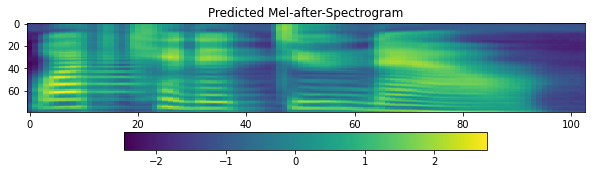

In [9]:
start = time.time()
mel_output_tflite = fastspeechlite.infer(sentences[3])
end = time.time()
print(f"TFLite inference time: {end-start}s")
mel_after = tf.reshape(mel_output_tflite, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_after), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

### Conversion of MBMelgan to TFLite

In [10]:
with open('examples/multiband_melgan/conf/multiband_melgan.v1.yaml') as f:
    config = yaml.load(f, Loader=yaml.Loader)

config = MultiBandMelGANGeneratorConfig(**config["generator_params"])
class TFMBMelGANGenerator(TFMelGANGenerator):
    def __init__(self, config, **kwargs):
        super().__init__(config, **kwargs)
        self.pqmf = TFPQMF(config=config, name='pqmf')
        
    def build(self, input_shape):
        self.pqmf.build(input_shape)
        self.built = True
    
    @tf.function(experimental_relax_shapes=True,input_signature=[tf.TensorSpec(shape=[None, None, 80], dtype=tf.float32)])
    def call(self, mels):
        mb_audios = super().call(mels)
        audios = self.pqmf.synthesis(mb_audios)
        return audios

mb_melgan = TFMBMelGANGenerator(config, name="mb_melgan")
fake_mels = tf.random.uniform(shape=[1, 256, 80], dtype=tf.float32)
audios = mb_melgan(fake_mels)[0, : ,0]
mb_melgan.summary()
mb_melgan.load_weights("generator-940000.h5")
concrete_func = mb_melgan.call.get_concrete_function()
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
mbmlite = converter.convert()
# Save the TF Lite model.
with tf.io.gfile.GFile('mbm_quant.tflite', 'wb') as f:
  f.write(mbmlite)
print('Model saved to mbm_quant.tflite file')
print('Model size is %f MBs.' % (len(mbmlite) / 1024 / 1024.0) )

Model: "mb_melgan"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, None, 4)           2534356   
_________________________________________________________________
pqmf (TFPQMF)                multiple                  0         
Total params: 2,534,356
Trainable params: 2,534,356
Non-trainable params: 0
_________________________________________________________________
Model saved to mbm_quant.tflite file
Model size is 6.482605 MBs.


### MBMelganLite inference test

In [11]:
class MBMelganLite:
  def __init__(self,path):
    # Load TFLite model and allocate tensors.
    self.interpreter = tf.lite.Interpreter(model_path=path)
    # Get input and output tensors.
    self.inputs = self.interpreter.get_input_details()
    self.outputs = self.interpreter.get_output_details()
    self.current_shape = self.inputs[0]['shape']
  
  def printDetails(self): 
    for x in self.inputs:
      print(x)
    for x in self.outputs:
      print(x)

  def infer(self,mel):
    # Resize if input length different, assuming batch size is always 1.
    if self.current_shape[1] is not mel.shape[1]:
      print(f"Input shape: {mel.shape} , interpreter shape: {self.current_shape}")
      print("Warning: Latency might be affected due to change in input shape")
      self.interpreter.resize_tensor_input(self.inputs[0]['index'], list(mel.shape))
      self.interpreter.allocate_tensors()
      self.current_shape = mel.shape
    self.interpreter.set_tensor(self.inputs[0]['index'], mel)
    self.interpreter.invoke()
    tflite_results = self.interpreter.get_tensor(self.outputs[0]['index'])
    return tflite_results

mbmelganlite = MBMelganLite(path="mbm_quant.tflite")

In [12]:
start = time.time()
audio_mblite = mbmelganlite.infer(mel_output_tflite)[0, :, 0]
print(f"Time taken: {time.time() - start}s")
Audio(data=audio_mblite, rate=22050)

Input shape: (1, 103, 80) , interpreter shape: [ 1  1 80]
Time taken: 6.370621204376221s


## Combined TFlite inference test

In [13]:
fastspeechlite = FastSpeechLite(path='fastspeech_quant.tflite')
mbmelganlite = MBMelganLite(path="mbm_quant.tflite")
for sentence in sentences[1:]:
  start = time.time()
  mel_output_tflite = fastspeechlite.infer(sentence)
  audio_mblite = mbmelganlite.infer(mel_output_tflite)[0, :, 0]
  print(f"Time taken: {time.time() - start}s")

Input shape: [1, 28] , interpreter shape: [1 1]
Input shape: (1, 143, 80) , interpreter shape: [ 1  1 80]
Time taken: 17.55701231956482s
Input shape: [1, 31] , interpreter shape: [1, 28]
Input shape: (1, 162, 80) , interpreter shape: (1, 143, 80)
Time taken: 19.811264276504517s
Input shape: [1, 19] , interpreter shape: [1, 31]
Input shape: (1, 103, 80) , interpreter shape: (1, 162, 80)
Time taken: 12.57641887664795s
